# Sampler

> Toolbox to emulate data collection

In [1]:
#| default_exp sampler

In [146]:
#| hide
from nbdev.showdoc import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [186]:
#| export
import rasterio
from rasterio import transform
import fastcore.all as fc
import matplotlib.pyplot as plt
from trufl.utils import reproject_raster
import geopandas as gpd
from typing import List

from trufl.utils import gridder

In [188]:
#|export
class Sampler:
    def __init__(self, 
               fname_raster:str, # The path to the raster file.
               band:int=1, # The band number to use. Defaults to 1.
               id_name:str='loc_id'
               ):
        "Emulate data collection. Provided a set of location, return values sampled from given raster file."
        fc.store_attr()
        with rasterio.open(fname_raster) as src:
            self.band_data = src.read(band)
            self.affine = src.transform
    
    def to_geodataframe(self, 
                        geoseries:gpd.GeoSeries, # The locations
                        values:List[float] # The sampled values
                        ) -> gpd.GeoDataFrame: 
        gdf = geoseries.to_frame(name='geometry').explode(index_parts=False)
        gdf = gdf.assign(value=values)
        return gdf.reset_index(names=self.id_name)
    
    def sample(self, 
               geoseries:gpd.GeoSeries # The locations
               ) -> gpd.GeoDataFrame:
        coords = [(x, y) for x, y in geoseries.get_coordinates().values]
        pixel_coords = [transform.rowcol(self.affine, *pair) for pair in coords]
        values = [self.band_data[int(y), int(x)] for (x, y) in pixel_coords]
        return self.to_geodataframe(geoseries, values)

In [189]:
fname_raster = './files/ground-truth-02-4326-simulated.tif'
gdf_grid = gridder(fname_raster, nrows=10, ncols=10)
loc_id = 1
n_pts = 100
sampling_locs = gdf_grid.loc[gdf_grid.loc_id == loc_id].sample_points(n_pts)

In [190]:
sampler = Sampler(fname_raster)
gdf_samples = sampler.sample(sampling_locs)

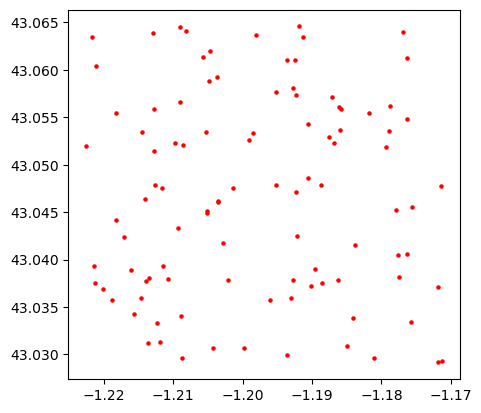

In [191]:
ax = gdf_samples.plot(markersize=5, c='red')
# gdf_grid.boundary.plot(ax=ax);


In [85]:
#| hide
import nbdev; nbdev.nbdev_export()